In [1]:
import numpy as np
import pandas as pd
import pandas_ta as ta
import sqlite3
import matplotlib.pyplot as plt

In [2]:
conn = sqlite3.connect("../database.db")

df = pd.read_sql("SELECT * FROM Ticker_1H WHERE Ticker = 'MSFT'", con=conn)
df.head()

,Datetime,Open,High,Low,Close,Volume,Ticker,InsertTime
0,2024-01-16 09:30:00.000000,392.750000,393.700012,389.470001,392.119995,8262760,MSFT,2026-01-13 11:05:14.285670
1,2024-01-16 10:30:00.000000,392.095001,393.220001,390.320007,391.649994,3330125,MSFT,2026-01-13 11:05:14.285670
2,2024-01-16 11:30:00.000000,391.690002,392.319885,389.730011,389.779999,2038955,MSFT,2026-01-13 11:05:14.285670
3,2024-01-16 12:30:00.000000,389.760010,390.000000,387.622894,389.010010,2296409,MSFT,2026-01-13 11:05:14.285670
4,2024-01-16 13:30:00.000000,389.019989,389.750000,388.000000,388.662994,1597837,MSFT,2026-01-13 11:05:14.285670


In [3]:
df.Ticker.drop_duplicates().to_numpy()

array(['MSFT'], dtype=object)

In [4]:
df = df[["Datetime", "Close"]]
df["Datetime"] = pd.to_datetime(df["Datetime"])
df = df.set_index("Datetime")
df.head()

,Close
Datetime,
2024-01-16 09:30:00,392.119995
2024-01-16 10:30:00,391.649994
2024-01-16 11:30:00,389.779999
2024-01-16 12:30:00,389.010010
2024-01-16 13:30:00,388.662994


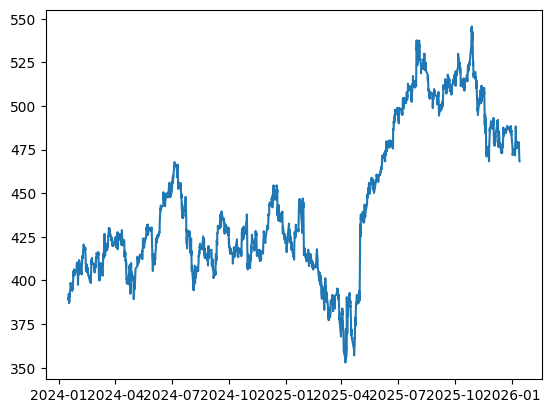

In [5]:
plt.plot(df.index, df.Close)

In [5]:
train_size = 2800
val_size = 300

In [ ]:
from sklearn.preprocessing import StandardScaler

# train_size = 2800
# val_size = 300

df_np = df.to_numpy()
scale_to = df.to_numpy()[:train_size]
labels = df.Close.to_numpy()

scaler = StandardScaler()
scaler.fit(scale_to)

df_np = scaler.transform(df_np)

In [8]:
df_np = df.to_numpy()

In [24]:
def create_window(predictors, window_size=50):
    df_np = predictors
    X = []
    y = []


    for i in range(len(df_np) - window_size):
        row = np.array([[a] for a in df_np[i:i+window_size]]) #.reshape(window_size, 5) # Does [[a] [b] [c]...]
        label = df_np[i+window_size]

        X.append(row)
        y.append(label)

    return np.array(X), np.array(y)

In [27]:
X, y = create_window(df_np)
X.shape, y.shape

((3428, 50, 1, 1), (3428, 1))

In [28]:
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((2800, 50, 1, 1),
 (2800, 1),
 (300, 50, 1, 1),
 (300, 1),
 (328, 50, 1, 1),
 (328, 1))

In [34]:
X_train, y_train = X_train.reshape(X_train.shape[:3]), y_train.reshape(y_train.shape[:3])
X_val, y_val = X_val.reshape(X_val.shape[:3]), y_val.reshape(y_val.shape[:3])
X_test, y_test = X_test.reshape(X_test.shape[:3]), y_test.reshape(y_test.shape[:3])

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((2800, 50, 1), (2800, 1), (300, 50, 1), (300, 1), (328, 50, 1), (328, 1))

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam

2026-02-12 20:15:30.901441: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-12 20:15:30.963787: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-12 20:15:32.569755: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [56]:
model1 = Sequential()
model1.add(InputLayer((50, 1)))
model1.add(LSTM(96, return_sequences=True))
model1.add(Dropout(0.25))
model1.add(LSTM(96, return_sequences=True))
model1.add(Dropout(0.25))
model1.add(LSTM(96, return_sequences=True))
model1.add(Dropout(0.25))
model1.add(LSTM(96))
model1.add(Dropout(0.25))
# model1.add(Dense(8, "relu"))
model1.add(Dense(1, "linear"))

model1.summary()


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_19 (LSTM)                  │ (None, 50, 96)         │        37,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 50, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 50, 96)         │        74,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 50, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 50, 96)         │        74,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 50, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_22 (LSTM)                  │ (None, 96)             │        74,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 260,065 (1015.88 KB)

 Trainable params: 260,065 (1015.88 KB)

 Non-trainable params: 0 (0.00 B)

In [57]:
mcp = ModelCheckpoint("model1/best_model.keras", save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001))
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, callbacks=[mcp])

Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 12s 82ms/step - loss: 175728.7969 - val_loss: 244621.5469
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 166962.4531 - val_loss: 236032.0312
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 160018.2344 - val_loss: 227911.0469
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 153478.5781 - val_loss: 220118.2031
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 147095.8750 - val_loss: 212562.9531
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 141081.6875 - val_loss: 205247.8906
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - loss: 135156.3281 - val_loss: 198139.4375
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 129439.7734 - val_loss: 191237.7188
Epoch 9/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - loss: 124022.6641 - val_loss: 184532.9375
Epoch 10/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 118725.7500 - val_loss: 178025.0312
Epoch 11/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/s

In [51]:
from tensorflow.keras.models import load_model

model1_loaded = load_model("model1/best_model.keras")

In [52]:
y_pred = model1_loaded.predict(X_test).flatten()

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step


In [53]:
train_true = np.full((len(X)), np.nan)
val_true = np.full((len(X)), np.nan)
test_true = np.full((len(X)), np.nan)
test_pred = np.full((len(X)), np.nan)

train_true[:train_size] = y_train.flatten()
val_true[train_size:train_size+val_size] = y_val.flatten()
test_true[train_size+val_size:] = y_test.flatten()
test_pred[train_size+val_size:] = y_pred


In [54]:
graph_df = pd.DataFrame({
    "Train-True": train_true, 
    "Val-True": val_true, 
    "Test-True": test_true, 
    "Test-Preds": test_pred})
graph_df

,Train-True,Val-True,Test-True,Test-Preds
0,406.416992,NaN,NaN,NaN
1,405.432007,NaN,NaN,NaN
2,405.450012,NaN,NaN,NaN
3,403.200012,NaN,NaN,NaN
4,403.470001,NaN,NaN,NaN
...,...,...,...,...
3423,NaN,NaN,479.140015,201.8237
3424,NaN,NaN,479.239990,201.8237
3425,NaN,NaN,477.190002,201.8237
3426,NaN,NaN,468.239990,201.8237


<Axes: >

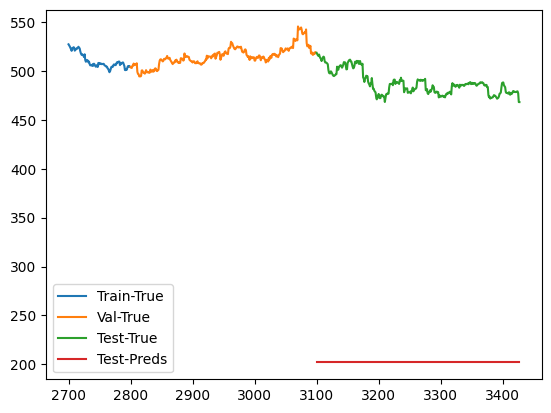

In [55]:
graph_df.iloc[2700:, :].plot()

<Axes: >

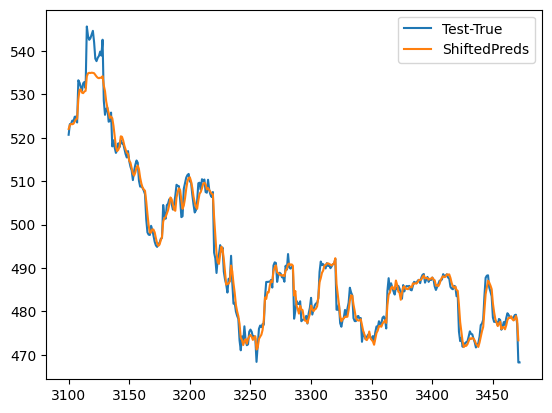

In [35]:
graph_df["ShiftedPreds"] = graph_df["Test-Preds"].shift(-1)
graph_df[["Test-True", "ShiftedPreds"]].iloc[train_size+val_size:].plot()